# Solve the problem leveraging ResNet152v2 architecture
In this notebook, we will use the ResNet152v2 architecture.

First, we'll try a simple **feature extraction** and after we will go on with **fine tuning**.

#Import Libraries
First of all, let's import all the libraries we will need later.

In [13]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load dataset from Google Drive
The dataset and the distractor are stored on Google Drive, we will unzip them locally to improve the performance

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -q "/content/drive/My Drive/CV_Birds/Dataset.zip" -d "/content"

In [ ]:
!unzip -q '/content/drive/My Drive/CV_Birds/mirflickr.zip' -d '/content'

# Set parameters
Let's define some global parameter for this notebook

In [4]:
DATASET_PATH = "/content/Dataset"
TRAINING_PATH = DATASET_PATH + '/train'
VALIDATION_PATH = DATASET_PATH + '/valid'
TEST_PATH = DATASET_PATH + '/test'
DISTRACTOR_PATH = '/content/mirflickr'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/CV_Birds/models/ResNet152v2"

HISTORIES_FOLDER = "/content/drive/My Drive/CV_Birds/histories/ResNet152v2"

FEATURES_FOLDER = '/content/drive/My Drive/CV_Birds/features'
TRAINING_FEATURES_FOLDER = FEATURES_FOLDER + '/training/ResNet152v2'
TEST_FEATURES_FOLDER = FEATURES_FOLDER + '/test/ResNet152v2'
VALIDATION_FEATURES_FOLDER = FEATURES_FOLDER + '/validation/ResNet152v2'
DISTRACTOR_FEATURES_FOLDER = FEATURES_FOLDER + '/distractor/ResNet152v2'

# Default values to load the dataset
BATCH_SIZE = 128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
SEED = 24
NUM_CLASSES = 325

# Utility functions

In [19]:
from IPython.core.pylabtools import figsize
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(SEED)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(SEED)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(SEED)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size, shuffle=True):
  '''
  load_training_set loads the training set from the "train" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    seed=SEED,
    label_mode='categorical',
    shuffle=shuffle)

def load_validation_set (image_height, image_width, batch_size, shuffle=True):
  '''
  load_validation_set loads the validation set from the "valid" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    seed=SEED,
    label_mode='categorical',
    shuffle=shuffle)

def load_test_set (image_height, image_width, batch_size, shuffle=False):
  '''
  load_test_set loads the test set from the "test" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    seed=SEED,
    shuffle=shuffle,
    label_mode='categorical')

def load_distractor_set (image_height, image_width, batch_size):
  '''
  load_distractor_set is used to load the distractor dataset contained in the "mirflickr" folder
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the distractor set
  '''
  return image_dataset_from_directory(
    DISTRACTOR_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    seed=SEED,
    labels=None,
    label_mode=None)

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="categorical_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="categorical_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 50, patience = 5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')

  # save on Drive also the history object
  history_df = pd.DataFrame(history.history)
  with open(HISTORIES_FOLDER + '/' + model_name + '.csv', mode='w+') as f:
    history_df.to_csv(f)

  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to show some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.argmax(y_score, axis=-1)
  y_true = tf.concat([np.argmax(labels_batch, axis=1) for data_batch, labels_batch in test_dataset], axis = 0)
  confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  print("Confusion matrix: ")
  print(confusion_matrix)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))

# Load Dataset

In [7]:
set_seed()
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 47332 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.


In [ ]:
distractor_dataset = load_distractor_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 25000 files belonging to 1 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    print(np.argmax(labels_batch, axis=-1)) # ground truth
    break

data batch shape: (128, 224, 224, 3)
labels batch shape: (128, 325)
[145 296 141  82 196 285  37 174 108  92  68 122 285 191 255 229 249 171
 181 289 286 303 264  44  38 105 230  41  46   3 103  61  15 240 222  20
  20 168 149 108 110 117 119 120  21  24  61 231 109 107   1 136 138  84
  64 231 202 274 295 284 159 190  97  21   9 134 298 245  76   4 297 147
 116 252  66 284 120 182  58 143  24  52 101  82 126 287  61 253  14 153
 214  60 301  56 289 132  85 175  45  87 159 100 147  22 226 319 205  42
 206  48 250 222 263 111 120 195  15 240 118 136 128 141 156   2 212 142
 115  55]


#Feature extraction
We will now use the convolutional base to directly extract the features. The ResNet152v2 use a GlobalAveragePooling layer before the final classification, and the output has a dimension of 2048 values, that will be the dimension of our feature vector.

In [ ]:
conv_base = keras.applications.resnet_v2.ResNet152V2(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))
conv_base.summary()

234561536/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
feature_extractor = tf.keras.models.Sequential([
    conv_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 300s 813ms/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 13s 1s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 10s 832ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 2048) (1625, 2048) (1625, 2048)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/feature_extraction.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/feature_extraction.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/feature_extraction.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 359s 2s/step
(25000, 2048)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/feature_extraction.npy', distractor_features)

# MLP on top of the convnet base
First of all, we fix the bottom layers of the pretrained network and learn a new Multi-layer Perceptron (MLP) classifier on top of them

In [ ]:
conv_base.trainable = False

## Experiment 1: Global Average Pooling

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/30
370/370 [==============================] - ETA: 0s - loss: 1.2356 - accuracy: 0.7566
Epoch 00001: val_loss improved from inf to 0.30004, saving model to /content/models/GlobalAveragePooling_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 739s 2s/step - loss: 1.2356 - accuracy: 0.7566 - val_loss: 0.3000 - val_accuracy: 0.9385
Epoch 2/30
370/370 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.9315
Epoch 00002: val_loss improved from 0.30004 to 0.20765, saving model to /content/models/GlobalAveragePooling_feature_extraction.h5
370/370 [==============================] - 707s 2s/step - loss: 0.3095 - accuracy: 0.9315 - val_loss: 0.2077 - val_accuracy: 0.9446
Epoch 3/30
370/370 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9639
Epoch 00003: val_loss improved from 0.20765 to 0.17061, saving model to /content/models/GlobalAveragePooling_feature_extraction.h5
370/370 [==============================] - 706s 2s/step - loss: 0.1799 - accuracy: 0.9639 - val_loss: 0.1706 - val_accuracy: 0.9557
Epoch 4/30
370/370 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9805
Epoch 00004: val_loss improved from 0.17061 to 0.14805

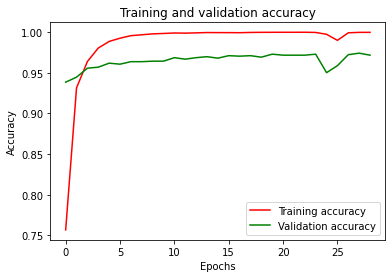

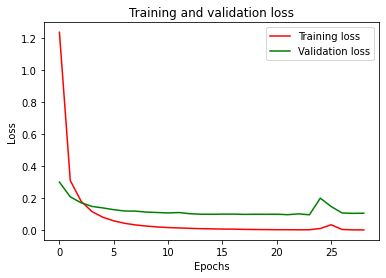

In [ ]:
run_model(model1, 'GlobalAveragePooling_feature_extraction', epochs = 30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_feature_extraction.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     0.8000    0.8000    0.8000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    0.8000    0.8889         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    0.8000    0.8889         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     0.8333    1.0000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_feature_extraction.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 52s 2s/step - loss: 0.0795 - accuracy: 0.9754


[0.07948505878448486, 0.9753845930099487]

## Experiment 2: One dense layer with 512 neurons
We try to lower the dimension of our feature vector, adding a dense layer of 512 neurons after the global average pooling layer.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu') (x) # feature vector
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 1.1851 - accuracy: 0.7246
Epoch 00001: val_loss improved from inf to 0.30279, saving model to /content/models/OneDense256_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 695s 2s/step - loss: 1.1851 - accuracy: 0.7246 - val_loss: 0.3028 - val_accuracy: 0.9188
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.9051
Epoch 00002: val_loss improved from 0.30279 to 0.22446, saving model to /content/models/OneDense256_feature_extraction.h5
370/370 [==============================] - 671s 2s/step - loss: 0.3461 - accuracy: 0.9051 - val_loss: 0.2245 - val_accuracy: 0.9372
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9430
Epoch 00003: val_loss improved from 0.22446 to 0.19375, saving model to /content/models/OneDense256_feature_extraction.h5
370/370 [==============================] - 671s 2s/step - loss: 0.2040 - accuracy: 0.9430 - val_loss: 0.1938 - val_accuracy: 0.9446
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9655
Epoch 00004: val_loss improved from 0.19375 to 0.18980, saving model to 

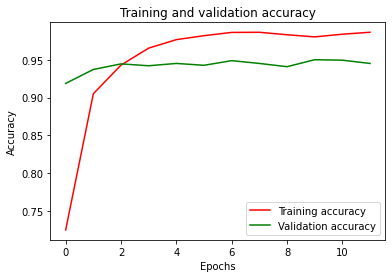

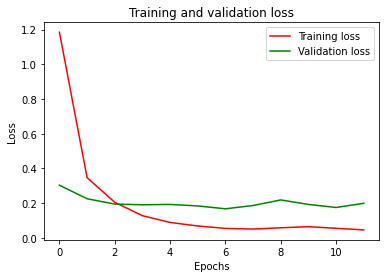

In [ ]:
run_model(model2, 'OneDense512_feature_extraction', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_feature_extraction.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     0.8000    0.8000    0.8000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     0.8333    1.0000    0.9091         5
           8     0.8333    1.0000    0.9091         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    0.8000    0.8889         5
          11     0.7143    1.0000    0.8333         5
          12     1.0000    1.0000    1.0000         5
          13     0.8000    0.8000    

## Experiment 3: One dense layer with 512 neurons and Dropoout
We try to add regularization techniques to reduce the slight overfitting visible in the previous experiment.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu') (x) # feature vector
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 1.9472 - accuracy: 0.5526
Epoch 00001: val_loss improved from inf to 0.38873, saving model to /content/models/OneDense512_Dropout_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 696s 2s/step - loss: 1.9472 - accuracy: 0.5526 - val_loss: 0.3887 - val_accuracy: 0.9071
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.7777 - accuracy: 0.7843
Epoch 00002: val_loss improved from 0.38873 to 0.25094, saving model to /content/models/OneDense512_Dropout_feature_extraction.h5
370/370 [==============================] - 663s 2s/step - loss: 0.7777 - accuracy: 0.7843 - val_loss: 0.2509 - val_accuracy: 0.9305
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.8373
Epoch 00003: val_loss improved from 0.25094 to 0.19745, saving model to /content/models/OneDense512_Dropout_feature_extraction.h5
370/370 [==============================] - 663s 2s/step - loss: 0.5676 - accuracy: 0.8373 - val_loss: 0.1975 - val_accuracy: 0.9446
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8654
Epoch 00004: val_loss improved from 0.19745 to 0.18117, 

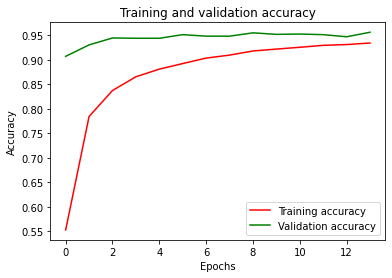

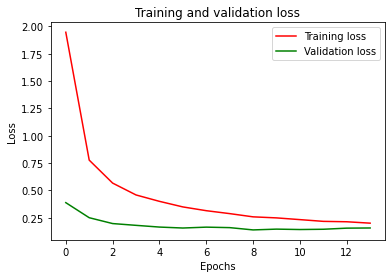

In [ ]:
run_model(model3, 'OneDense512_Dropout_feature_extraction', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_feature_extraction.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         5
           2     0.8333    1.0000    0.9091         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    0.8000    0.8889         5
           7     0.8333    1.0000    0.9091         5
           8     1.0000    1.0000    1.0000         5
           9     0.8333    1.0000    0.9091         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    0.8000    0.8889         5
          13     1.0000    0.8000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_feature_extraction.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 31s 2s/step - loss: 0.1172 - accuracy: 0.9631


[0.11721468716859818, 0.9630769491195679]

### Feature Extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_feature_extraction.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense').output)

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 633s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 24s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 20s 2s/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 512) (1625, 512) (1625, 512)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/OneDense512_Dropout_feature_extraction.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/OneDense512_Dropout_feature_extraction.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/OneDense512_Dropout_feature_extraction.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 334s 2s/step
(25000, 512)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/OneDense512_Dropout_feature_extraction.npy', distractor_features)

# Fine tuning
We can now try fine-tuning to adapt the network to our dataset

## Unfreeze the 5-th block
Firstly, we try to unfreeze only the layers of the 5-th block of the ResNet architecture.

### Experiment 1: Global Average Pooling

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_feature_extraction.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model1.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 0.1100 - accuracy: 0.9714
Epoch 00001: val_loss improved from inf to 0.12855, saving model to /content/models/GlobalAveragePooling_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 757s 2s/step - loss: 0.1100 - accuracy: 0.9714 - val_loss: 0.1285 - val_accuracy: 0.9594
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9995
Epoch 00002: val_loss did not improve from 0.12855
370/370 [==============================] - 738s 2s/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.1297 - val_accuracy: 0.9612
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9999
Epoch 00003: val_loss improved from 0.12855 to 0.12376, saving model to /content/models/GlobalAveragePooling_fine_tuning.h5
370/370 [==============================] - 740s 2s/step - loss: 0.0077 - accuracy: 0.9999 - val_loss: 0.1238 - val_accuracy: 0.9618
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 00004: val_loss improved from 0.12376 to 0.11750, saving model to /content/models/GlobalAveragePooling_fine_tuning.h5
370/370 [========

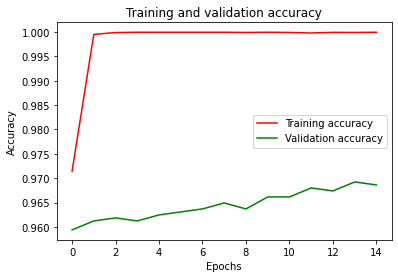

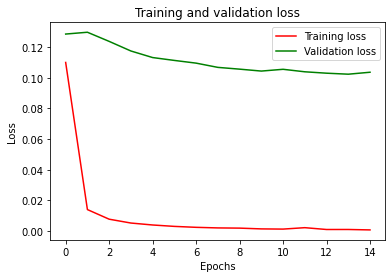

In [ ]:
run_model(model1, 'GlobalAveragePooling_fine_tuning', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     0.7500    0.6000    0.6667         5
           2     0.8333    1.0000    0.9091         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    0.8000    0.8889         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     0.8333    1.0000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 31s 2s/step - loss: 0.0831 - accuracy: 0.9760


[0.08308207988739014, 0.9760000109672546]

#### Feature Extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning.h5')
intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('global_average_pooling2d').input)
feature_extractor = tf.keras.models.Sequential([
    intermediate_layer_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 305s 820ms/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 10s 848ms/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 10s 830ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 2048) (1625, 2048) (1625, 2048)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/global_average_pooling_fine_tuning.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/global_average_pooling_fine_tuning.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/global_average_pooling_fine_tuning.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 355s 2s/step
(25000, 2048)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/global_average_pooling_fine_tuning.npy', distractor_features)

### Experiment 2: One dense layer with 512 neurons

In [ ]:
model2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_feature_extraction.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model2.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model2, learning_rate=1e-5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 0.9477
Epoch 00001: val_loss improved from inf to 0.13423, saving model to /content/models/OneDense512_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 396s 1s/step - loss: 0.2040 - accuracy: 0.9477 - val_loss: 0.1342 - val_accuracy: 0.9588
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.0432 - accuracy: 0.9949
Epoch 00002: val_loss improved from 0.13423 to 0.12368, saving model to /content/models/OneDense512_fine_tuning.h5
370/370 [==============================] - 382s 1s/step - loss: 0.0432 - accuracy: 0.9949 - val_loss: 0.1237 - val_accuracy: 0.9606
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9989
Epoch 00003: val_loss improved from 0.12368 to 0.11624, saving model to /content/models/OneDense512_fine_tuning.h5
370/370 [==============================] - 383s 1s/step - loss: 0.0208 - accuracy: 0.9989 - val_loss: 0.1162 - val_accuracy: 0.9612
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9996
Epoch 00004: val_loss improved from 0.11624 to 0.11151, saving model to /content/model

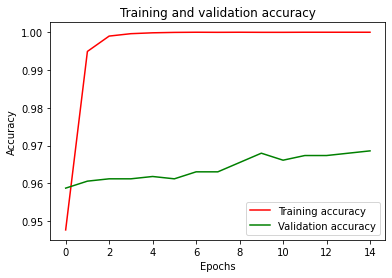

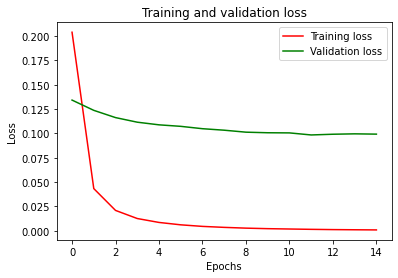

In [ ]:
run_model(model2, 'OneDense512_fine_tuning', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_fine_tuning.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    0.8000    0.8889         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    

#### Feature Extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_fine_tuning.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense_2').output)
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 318s 856ms/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 10s 851ms/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 10s 850ms/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 512) (1625, 512) (1625, 512)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/OneDense512_fine_tuning.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/OneDense512_fine_tuning.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/OneDense512_fine_tuning.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 174s 863ms/step
(25000, 512)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/OneDense512_fine_tuning.npy', distractor_features)

### Experiment 3: One dense layer with 512 neurons and Dropout

In [ ]:
model3 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_feature_extraction.h5')

set_trainable = False
# set the 5-th block as trainable
for layer in model3.get_layer('resnet152v2').layers:
    if layer.name == 'conv5_block1_1_conv': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model3, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8790
Epoch 00001: val_loss improved from inf to 0.13444, saving model to /content/models/OneDense512_Dropout_fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 818s 2s/step - loss: 0.4437 - accuracy: 0.8790 - val_loss: 0.1344 - val_accuracy: 0.9594
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9451
Epoch 00002: val_loss improved from 0.13444 to 0.11474, saving model to /content/models/OneDense512_Dropout_fine_tuning.h5
370/370 [==============================] - 784s 2s/step - loss: 0.1952 - accuracy: 0.9451 - val_loss: 0.1147 - val_accuracy: 0.9662
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9629
Epoch 00003: val_loss improved from 0.11474 to 0.10220, saving model to /content/models/OneDense512_Dropout_fine_tuning.h5
370/370 [==============================] - 786s 2s/step - loss: 0.1327 - accuracy: 0.9629 - val_loss: 0.1022 - val_accuracy: 0.9674
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9739
Epoch 00004: val_loss improved from 0.10220 to 0.09915, saving model t

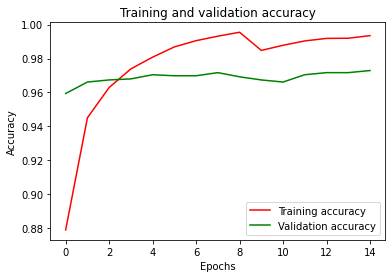

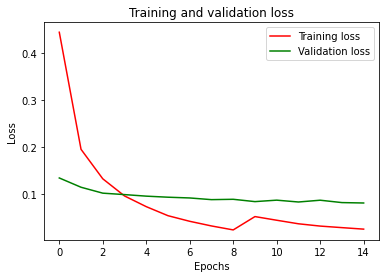

In [ ]:
run_model(model3, 'OneDense512_Dropout_fine_tuning', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_fine_tuning.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000         5
           2     0.8333    1.0000    0.9091         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_fine_tuning.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 31s 2s/step - loss: 0.0673 - accuracy: 0.9822


[0.06730511039495468, 0.9821538329124451]

#### Feature Extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense512_Dropout_fine_tuning.h5')
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer('dense').output)

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 660s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 22s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 22s 2s/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 512) (1625, 512) (1625, 512)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/OneDense512_Dropout_fine_tuning.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/OneDense512_Dropout_fine_tuning.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/OneDense512_Dropout_fine_tuning.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 356s 2s/step
(25000, 512)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/OneDense512_Dropout_fine_tuning.npy', distractor_features)

## Unfreeze also the 4-th block
We try also to unfreeze the 4-th block to see if there are improvement in the performances.

### Experiment 4: GlobalAveragePooling

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_feature_extraction.h5')

set_trainable = False
# set from the 4-th block as trainable
for layer in model4.get_layer('resnet152v2').layers:
  if layer.name == 'conv4_block1_1_conv': 
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
compile_model(model4, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

Epoch 1/15
370/370 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9546
Epoch 00001: val_loss improved from inf to 0.11974, saving model to /content/models/GlobalAveragePooling_fine_tuning_4th.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 863s 2s/step - loss: 0.1800 - accuracy: 0.9546 - val_loss: 0.1197 - val_accuracy: 0.9631
Epoch 2/15
370/370 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9992
Epoch 00002: val_loss did not improve from 0.11974
370/370 [==============================] - 838s 2s/step - loss: 0.0145 - accuracy: 0.9992 - val_loss: 0.1205 - val_accuracy: 0.9637
Epoch 3/15
370/370 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9998
Epoch 00003: val_loss improved from 0.11974 to 0.11558, saving model to /content/models/GlobalAveragePooling_fine_tuning_4th.h5
370/370 [==============================] - 855s 2s/step - loss: 0.0069 - accuracy: 0.9998 - val_loss: 0.1156 - val_accuracy: 0.9649
Epoch 4/15
370/370 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9999
Epoch 00004: val_loss improved from 0.11558 to 0.11216, saving model to /content/models/GlobalAveragePooling_fine_tuning_4th.h5
370/370 [

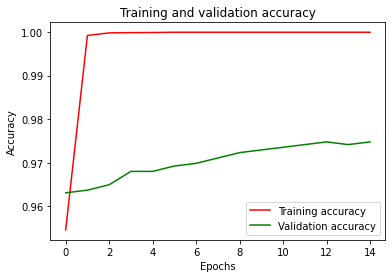

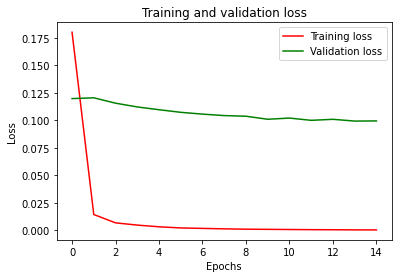

In [ ]:
run_model(model4, 'GlobalAveragePooling_fine_tuning_4th', epochs = 15)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5'))

Confusion matrix: 
tf.Tensor(
[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]], shape=(325, 325), dtype=int32)
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    0.8000    0.8889         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         5
           5     1.0000    1.0000    1.0000         5
           6     1.0000    1.0000    1.0000         5
           7     0.8333    1.0000    0.9091         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    1.0000    

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5')
model.evaluate(test_dataset)

13/13 [==============================] - 31s 2s/step - loss: 0.0703 - accuracy: 0.9828


[0.07034151256084442, 0.982769250869751]

#### Feature extraction

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/GlobalAveragePooling_fine_tuning_4th.h5')
intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('global_average_pooling2d').input)
feature_extractor = tf.keras.models.Sequential([
    intermediate_layer_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten()
])

In [ ]:
train_features = feature_extractor.predict(load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
test_features = feature_extractor.predict(load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)
validation_features = feature_extractor.predict(load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, shuffle=False), batch_size=BATCH_SIZE, verbose=1)

Found 47332 files belonging to 325 classes.
370/370 [==============================] - 686s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 26s 2s/step
Found 1625 files belonging to 325 classes.
13/13 [==============================] - 22s 2s/step


In [ ]:
print(train_features.shape, test_features.shape, validation_features.shape)

(47332, 2048) (1625, 2048) (1625, 2048)


In [ ]:
np.save(TRAINING_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', train_features)
np.save(TEST_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', test_features)
np.save(VALIDATION_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', validation_features)

In [ ]:
distractor_features = feature_extractor.predict(distractor_dataset, batch_size=BATCH_SIZE, verbose=1)
print(distractor_features.shape)

196/196 [==============================] - 360s 2s/step
(25000, 2048)


In [ ]:
np.save(DISTRACTOR_FEATURES_FOLDER + '/global_average_pooling_fine_tuning_4th.npy', distractor_features)